In [5]:
import numpy as np
import torch

In [6]:
n=int(1e4)
N=2
d=3
k=1
radii = [1] * N

In [11]:
def generate_data(n_samples, n_spheres, ambient_dim, 
                        manifold_dim, noise_std, embedding_type,
                        radii):
            data = []
            for i in range(n_spheres):
                    # sample N(0, I) and normalize
                    new_data = torch.randn((n_samples, manifold_dim+1))
                    norms = torch.linalg.norm(new_data, dim=1)
                    new_data = new_data / norms[:,None]
                    new_data = new_data * radii[i]

                    if embedding_type == 'random_isometry':
                        # random isometric embedding
                        embedding_matrix = torch.randn((ambient_dim, manifold_dim+1))
                        q, r = np.linalg.qr(embedding_matrix)
                        q = torch.from_numpy(q)
                        new_data = (q @ new_data.T).T
                    elif embedding_type == 'first':
                        # embedding into first manifold_dim + 1 dimensions
                        suffix_zeros = torch.zeros([n_samples, ambient_dim - new_data.shape[1]])
                        new_data = torch.cat([new_data, suffix_zeros], dim=1)
                    elif embedding_type == 'separating':
                        # embbedding which puts spheres in non-intersecting dimensions
                        if n_spheres * (manifold_dim + 1) > ambient_dim:
                            raise RuntimeError('Cant fit that many spheres. Enusre that n_spheres * (manifold_dim + 1) <= ambient_dim')
                        prefix_zeros = torch.zeros((n_samples, i * (manifold_dim + 1)))
                        new_data = torch.cat([prefix_zeros, new_data], dim=1)
                        suffix_zeros = torch.zeros([n_samples, ambient_dim - new_data.shape[1]])
                        new_data = torch.cat([new_data, suffix_zeros], dim=1)
                    elif embedding_type == 'along_axis':
                        # embbedding which puts spheres in non-intersecting dimensions
                        if (n_spheres - 1) + (manifold_dim + 1) > ambient_dim:
                            raise RuntimeError('Cant fit that many spheres.')
                        prefix_zeros = torch.zeros((n_samples, i))
                        new_data = torch.cat([prefix_zeros, new_data], dim=1)
                        suffix_zeros = torch.zeros([n_samples, ambient_dim - new_data.shape[1]])
                        new_data = torch.cat([new_data, suffix_zeros], dim=1)    
                    else:
                        raise RuntimeError('Unknown embedding type.')
                        
                    # add noise
                    new_data = new_data + noise_std * torch.randn_like(new_data)
                    data.append(new_data)

            data = torch.cat(data, dim=0)
            return data

In [12]:
data = generate_data(n, N, d, k, 0, 'along_axis', radii)

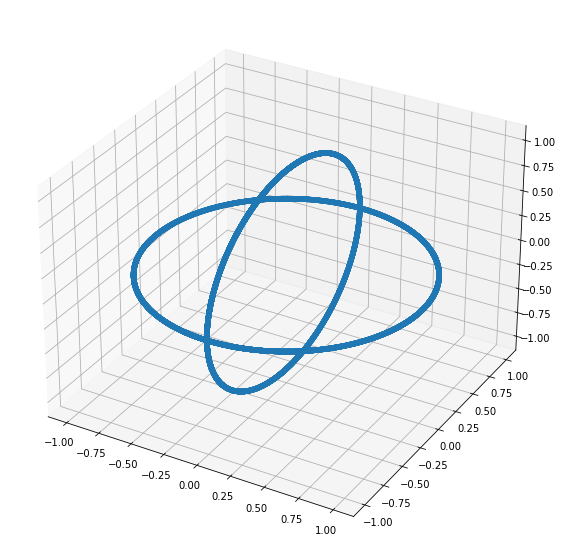

In [13]:
from matplotlib import pyplot as plt
plt_data = data.numpy()
fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection='3d'))
ax.scatter(plt_data[:,0], plt_data[:,1], plt_data[:,2])
fig.show()

In [27]:
from sklearn.decomposition import PCA
pca = PCA(n_components='mle')
pca.fit(data.numpy())
pca.n_components_

22

In [28]:
print(np.linalg.norm(plt_data, axis=1).mean().item())
print(np.linalg.norm(plt_data, axis=1).min().item())
print(np.linalg.norm(plt_data, axis=1).max().item())

1.0
0.9999998211860657
1.0000001192092896


In [41]:
data

tensor([[-0.9523, -0.3051,  0.0000],
        [-0.0862,  0.9963,  0.0000],
        [ 0.7963,  0.6048,  0.0000],
        ...,
        [ 0.0000, -0.1646, -0.9864],
        [ 0.0000,  0.6309, -0.7759],
        [ 0.0000, -0.4252, -0.9051]])